## Trying to replicate Berg et al, 2003. Assesment of textural variation in laminated sands with computer vision

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt


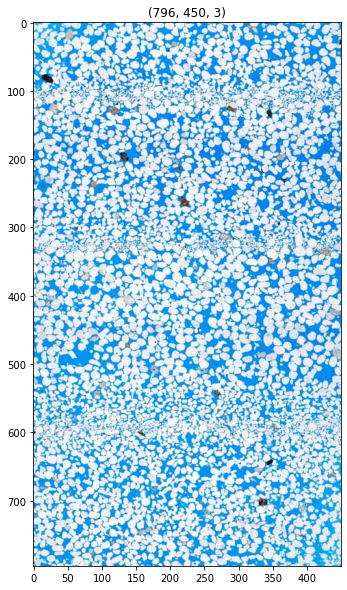

In [15]:
img = cv2.imread("sandLaminated.jpg", cv2.COLOR_RGB2BGR)

def plotRGB(img):
    plt.rcParams["figure.figsize"] = (20,10)
    imgrgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    plt.imshow(imgrgb)
    plt.title(imgrgb.shape)
    

plotRGB(img)



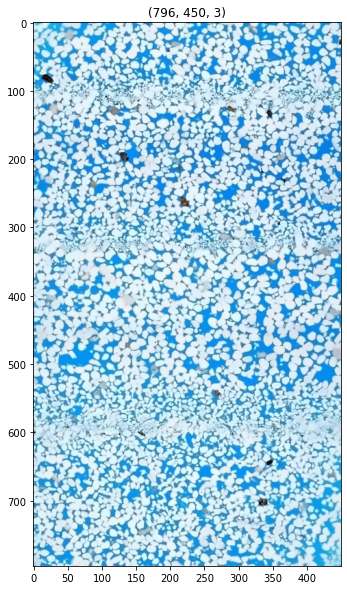

In [16]:
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

plotRGB(dst)

In [21]:
import pandas as pd
from sklearn.cluster import KMeans
def quantize_image(img, n_clusters):
    """
    Agrupa los pixeles en una imagen y regresa la imagen cuantizada
    
    img - 3D numpy array
    n_clusters - numero de clusters o colores en la imagen final 
    
    """
    
    img = np.array(img, dtype=np.float64)/255 # se normaliza
    
    m,l,k = img.shape[0],img.shape[1], img.shape[2] # redimesionando los datos
    df = pd.DataFrame(img.reshape(m*l, k))
    df.columns = ["R", "G", "B"]
    
    
    kmeans = KMeans(n_clusters= n_clusters)
    
    kmeans.fit(df.sample(5000))
    
    df["clusters"]= kmeans.predict(df)
    
    centers = pd.DataFrame(kmeans.cluster_centers_)
    
    centers["clusters"] = range(n_clusters)
    
    
    df["ind"] = df.index
    df = df.merge(centers)
    df = df.sort_values("ind")
    df = df.drop("ind", 1)
    
    quant_img = df.iloc[:,4:7].values

    quant_img = quant_img.reshape(img.shape[0], img.shape[1], img.shape[2])
    
    #quant_img = quant_img*255
    
    quant_img = np.array(quant_img, dtype=np.float64)
    

    return quant_img


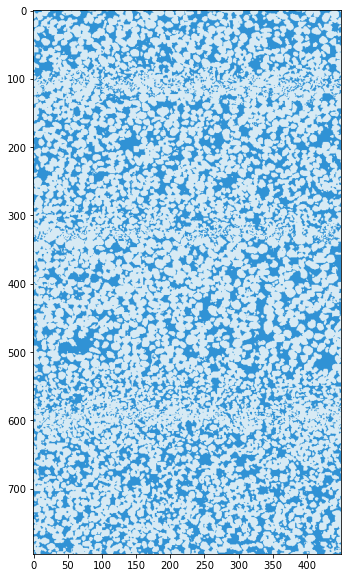

In [25]:
quantIMG = quantize_image(imgrgb, n_clusters=2)
plt.imshow(quantIMG)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


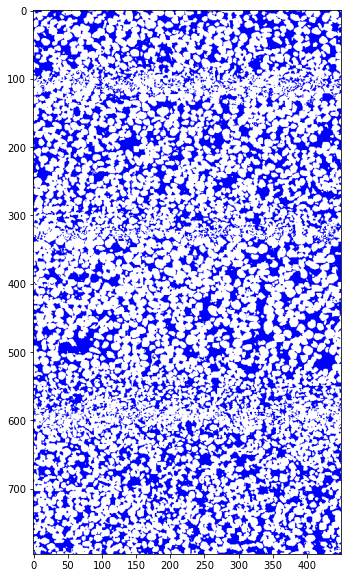

In [106]:
#print(quantIMG)
#gray = cv2.cvtColor(quantIMG, cv2.COLOR_BGR2GRAY)
ret1,th1 = cv2.threshold(quantIMG,0.8,255,cv2.THRESH_BINARY)
plt.imshow(th1)

In [128]:
from scipy import ndimage
from skimage import measure, color, io
import cv2

def doClusterQT(imgCon):
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(imgCon, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(dilated,-1,kernel)
    blur = cv2.GaussianBlur(dilated,(5,5),0)
    
    mask = blur == 255
    
    s = [[1,1,1], [1,1,1], [1,1,1]]

    labeled_mask, num_labels = ndimage.label(mask[:,:,0], structure=s)
    img = color.label2rgb(labeled_mask, bg_label=0)
    
    clusters = measure.regionprops(labeled_mask, imgCon[:,:,0])
    
    return len(clusters), img  
    
def doClusterQT2(imgCon):
    
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(imgCon,kernel,iterations = 1)
    dilated = cv2.dilate(eroded,kernel,iterations = 1)
    canny = cv2.Canny(dilated, 10,50) 
    kernel = np.ones((3,3),np.float32)/25
    dst = cv2.filter2D(dilated,-1,kernel)
    blur = cv2.GaussianBlur(dilated,(5,5),0)
    
    mask = canny == 255
    
    s = [[1,1,1], [1,1,1], [1,1,1]]
    
    labeled_mask, num_labels = ndimage.label(mask, structure=s)
    img2 = color.label2rgb(labeled_mask, bg_label=0)
    print(labeled_mask.shape, imgCon.shape)
    clusters = measure.regionprops(labeled_mask, imgCon[:,:,0])
    
    return len(clusters), img2  

(796, 450) (796, 450, 3)


Text(0.5, 1.0, '4704')

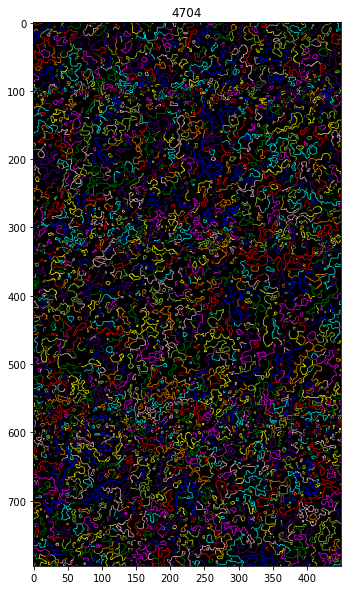

In [127]:

imgINT= np.uint8(th1)
clusters, imagen = doClusterQT2(imgINT)

plt.imshow(imagen)
plt.title(clusters)